In [1]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Link to "Folder_Labelled" file is shared along with the solution. This folder is shared through g-drive.
# In "Folder_Labelled", separate folders are created for each class of flowers that contain all the respective images of that class.
base_dir = '/content/drive/MyDrive/IE_643_Assignment2/Folder_Labelled'     #Please provide the link to "Folder_Labelled" folder here.
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),
    ]
)
dataset = ImageFolder(base_dir, transform=transformer)

In [4]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

cuda


In [5]:
#Only class-9 (class numbering starts from 0,1,2..) is selected. This roughly appears to be sunflower category.

mb_size = 4   #Mini-batch size

def get_indices(dataset, k):
    indices =  []
    sub_data = []
    for i in range(len(dataset.targets)):  #use train_labels if error with tragets 
        if dataset.targets[i] == k :  # or dataset.targets[i] == 4 or dataset.targets[i] == 6:
            indices.append(i)   #indices of data with labels 2, 4 or 6
            sub_data.append(dataset[i])
    return indices, sub_data

idx, sub_data = get_indices(dataset, 9)       #Class-9 is selected for training purpose.
print(len(idx))

from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(idx, test_size=0.1, random_state=42)

trainLoader = torch.utils.data.DataLoader(dataset,batch_size=mb_size, 
                                          sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_train))

80


In [6]:
idx, sub_data_change = get_indices(dataset, 10)       #Class-5 is selected for copying color.
print(len(idx))

idx_train, idx_test = train_test_split(idx, test_size=0.1, random_state=42)

checkLoader = torch.utils.data.DataLoader(dataset,batch_size=mb_size, 
                                          sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_train))

80


In [7]:
dataIter1 = iter(trainLoader)
dataIter2 = iter(checkLoader)


imgs1, labels1 = dataIter1.next()
imgs2, labels2 = dataIter2.next()

In [ ]:
imgs.shape  #shape of the tensor data obtained from the train loader

torch.Size([4, 3, 64, 64])

In [8]:
#visualization of data on a grid
def imshow(imgs):
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(vutils.make_grid(imgs, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

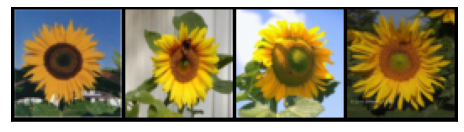

In [9]:
imshow(imgs1) #using imshow() to obtain the grid

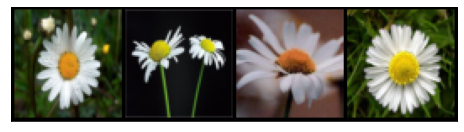

In [10]:
imshow(imgs2) #using imshow() to obtain the grid

![Generative Adversarial Network](https://www.kdnuggets.com/wp-content/uploads/generative-adversarial-network.png)

In [11]:
# Generator Code
nc = 3  # Number of channels in the training images. For color images this is 3
nz = 100  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator

class DC_Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4


            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.model(input)

In [12]:
#Discriminator Code
ndf = 64  # Size of feature maps in discriminator

class DC_Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [13]:
DC_G1 = DC_Gen().to(device)
DC_G2 = DC_Gen().to(device)
DC_D = DC_Dis().to(device)


#print(DC_G)
#print(DC_D)

In [14]:
lr = 1e-3  #learning rate
#optimizers for both models
g1_opt = opt.Adam(DC_G1.parameters(), lr=lr)
g2_opt = opt.Adam(DC_G2.parameters(), lr=lr)
d_opt = opt.Adam(DC_D.parameters(), lr=lr)


In [15]:
def get_elem():
  for i, data in enumerate(trainLoader):
    X, _ = data
  return X

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch:0,   G_loss:2.097601956791348,    D_loss:1.2492494798368878,       Recon_loss:0.011075753718614578


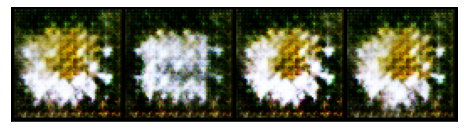

Epoch:1,   G_loss:2.1261875695652432,    D_loss:1.9117017189661663,       Recon_loss:0.009326175786554813


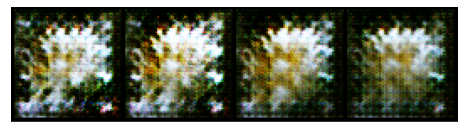

Epoch:2,   G_loss:2.109471791320377,    D_loss:1.7620515955819025,       Recon_loss:0.014849917963147163


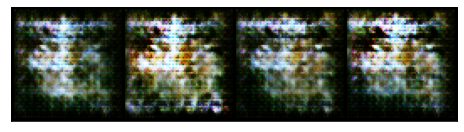

Epoch:3,   G_loss:2.2727015945646496,    D_loss:1.295080912609895,       Recon_loss:0.011484225280582905


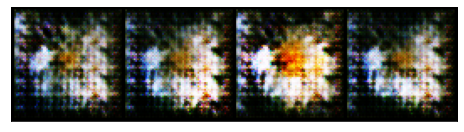

Epoch:4,   G_loss:1.6740404499901667,    D_loss:1.7220135860972934,       Recon_loss:0.013421646319329739


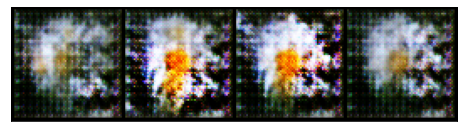

Epoch:5,   G_loss:2.0740195976363287,    D_loss:1.3926808337370555,       Recon_loss:0.011633394286036491


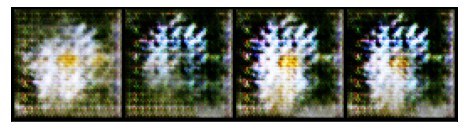

Epoch:6,   G_loss:2.1467156873808966,    D_loss:1.31016206741333,       Recon_loss:0.012003980576992035


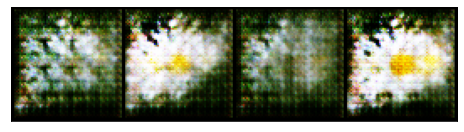

Epoch:7,   G_loss:1.7765815026230283,    D_loss:1.3963421318266127,       Recon_loss:0.01377647090703249


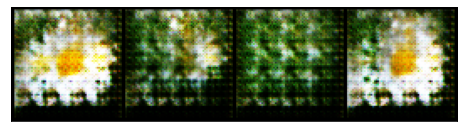

Epoch:8,   G_loss:2.121063815222846,    D_loss:1.2669883237944708,       Recon_loss:0.008375147357583046


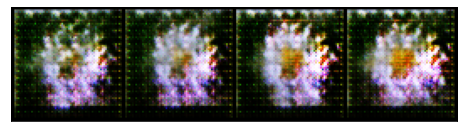

Epoch:9,   G_loss:1.7951894286606047,    D_loss:1.8757898923423555,       Recon_loss:0.01167099829763174


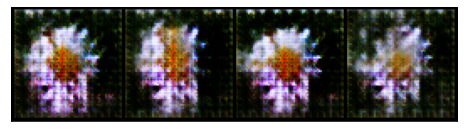

KeyboardInterrupt: ignored

In [40]:
epoch_list=[]
g_loss_list=[]
d_loss_list=[]
train_obj_list=[]
for epoch in range(300):
    G_loss_run = 0.0
    D_loss_run = 0.0
    
    for i, data in enumerate(checkLoader):
        X, _ = data
        X = X.to(device)        
        #X = X.view(X.size(0), -1)
        mb_size = X.size(0)
        
        one_labels = torch.ones(mb_size, device=device)
        zero_labels = torch.zeros(mb_size, device=device)
        
        z = get_elem()
        z = z.to(device)
        
        D_real = DC_D(X)
        D_fake = DC_D(DC_G1(z))
        
        D_real_loss = F.binary_cross_entropy(D_real.view(-1), one_labels)  #loss -(1/m)(log D(x))
        D_fake_loss = F.binary_cross_entropy(D_fake.view(-1), zero_labels)  #loss -(1/m)(log(1-D(G(z))))
        D_loss = D_real_loss + D_fake_loss
        
        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()
        
        z = get_elem()
        z = z.to(device)
       
        D_fake = DC_D(DC_G1(z))
        G_loss =  F.binary_cross_entropy(D_fake.view(-1), one_labels)  #loss -(1/m)(log (1-D(G(z))))
        
        g1_opt.zero_grad()
        G_loss.backward()
        g1_opt.step()

        recon = DC_G2(DC_G1(z))
        recon_loss=nn.MSELoss(size_average=True)(recon, z)
        g1_opt.zero_grad()
        g2_opt.zero_grad()
        recon_loss.backward()
        g1_opt.step()
        g2_opt.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
        
    print('Epoch:{},   G_loss:{},    D_loss:{},       Recon_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1), recon_loss/(i+1)))
    epoch_list.append(epoch)
    g_loss_list.append(G_loss_run/(i+1))
    d_loss_list.append(D_loss_run/(i+1))
    train_obj_list.append((G_loss_run/(i+1)) + (D_loss_run/(i+1)))
    
    with torch.no_grad():
        samples = DC_G1(z).detach().cpu()
        samples = samples.view(samples.size(0), 3, 64, 64)
        imshow(samples)
    

This is around epoch 250.

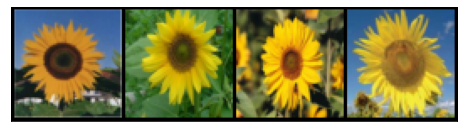

In [41]:
        samples = get_elem()
        samples = samples.view(samples.size(0), 3, 64, 64)
        imshow(samples)

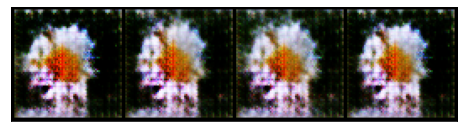

In [42]:
    with torch.no_grad():
        samples = DC_G1(samples.to(device)).detach().cpu()
        samples = samples.view(samples.size(0), 3, 64, 64)
        imshow(samples)

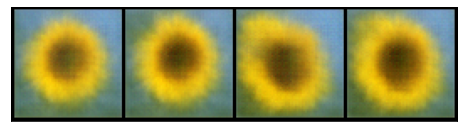

In [43]:
    with torch.no_grad():
        samples = DC_G2(DC_G1(z)).detach().cpu()
        samples = samples.view(samples.size(0), 3, 64, 64)
        imshow(samples)

Some images during training.

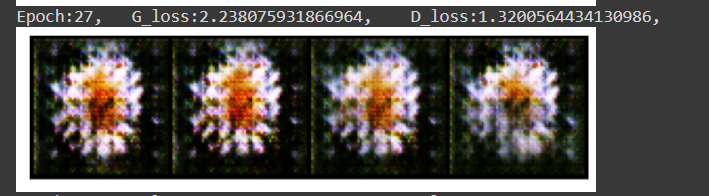

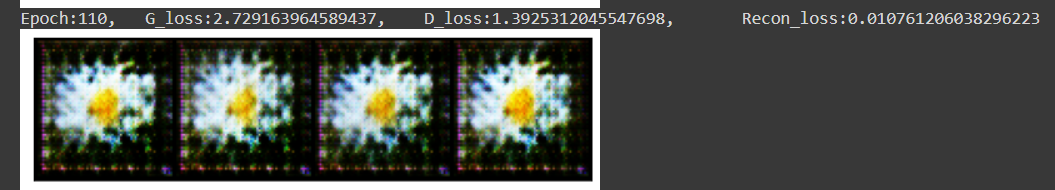